In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# HIDDEN
palette = sns.color_palette('Set2')

def plot_decision_boundary(X, y, theta):
    """
    Plot X1, X2 for y=0 and y=1.
    Then plot a decision boundary between y=0 and y=1.
    """
    plt.scatter(X[y==0, 0], X[y==0, 1], color=palette[0], alpha=0.7)
    plt.scatter(X[y==1, 0], X[y==1, 1], color=palette[1], alpha=0.7)
    
    z = np.zeros([100, 100])
    uu = np.linspace(-3, 7, 100)
    vv = np.linspace(-3, 7, 100)
    for i, u in enumerate(uu):
        for j, v in enumerate(vv):
            z[i, j] = (pf.transform([[u, v]]) @ theta.T).item()
    plt.contour(uu, vv, z.T, [0])
    
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')

## (outline, delete before merging)

- Loss function for logistic regression:
$$
L(\theta, X, y) = \frac{1}{n} \sum_{i} \left(-y_i \ln \left(f_{\hat\theta} \left(X_i\right) \right) - \left(1 - y_i \right) \ln \left(1 - f_{\hat\theta} (X_i)\right)\right)
$$
- Loss functions for regularized logistic regression (L1 and L2):
$$
L(\theta, X, y) = \frac{1}{n} \sum_{i} \left(-y_i \ln \left(f_{\hat\theta} \left(X_i\right) \right) - \left(1 - y_i \right) \ln \left(1 - f_{\hat\theta} (X_i)\right)\right) + \lambda\sum_{i}\left|\theta_i\right|
$$
$$
L(\theta, X, y) = \frac{1}{n} \sum_{i} \left(-y_i \ln \left(f_{\hat\theta} \left(X_i\right) \right) - \left(1 - y_i \right) \ln \left(1 - f_{\hat\theta} (X_i)\right)\right) + \lambda\sum_{i}{\theta_i}^2
$$
- Why do we use regularization?
    - To avoid overfitting 
    - When data are linearly separable, parameters will not converge
- Example inspired by [https://gist.github.com/kevindavenport/c524268ed0713371aa32#file-regularized_logistic_regression_intuition-ipynb](https://gist.github.com/kevindavenport/c524268ed0713371aa32#file-regularized_logistic_regression_intuition-ipynb)

## Visualizing Regularization in Classification

An easy way to visualize the importance of regularization in classification is to plot a decision boundary. Decision boundaries show the hyperplanes at which the classifier partitions observations. The classifier predicts all points on each side of the hyperplane to be of the same class.

In the example below, we use a toy dataset of $X_1$ and $X_2$ values; each point's label is depicted by its color. We attempt to fit a fifth degree polynomial `X_feats` as the feature set for Logistic Regression, and we begin by not specifying any regularization parameters:

In [4]:
# HIDDEN
np.random.seed(4)

# x1, x2 values for y=0
x1_0 = np.random.randn(100)
x2_0 = np.random.randn(100) + 2.3
y_0 = np.zeros(100)

# x1, x2 values for y=1
x1_1 = np.random.randn(100) + 2.2
x2_1 = np.random.randn(100)
y_1 = np.ones(100)

# Concatenate to create train set
X1 = np.c_[x1_0, x1_1]
X2 = np.c_[x2_0, x2_1]
X = np.r_[X1, X2]
y = np.hstack([y_0, y_1])

# Create polynomial features
pf = PolynomialFeatures(degree=5, interaction_only=False, include_bias=True)
X_feats = pf.fit_transform(X)

# Create a test set
x1_0_test = np.random.randn(74)
x2_0_test = np.random.randn(74) + 2.3
y_0_test = np.zeros(74)

x1_1_test = np.random.randn(74) + 2.2
x2_1_test = np.random.randn(74)
y_1_test = np.ones(74)

X1_test = np.c_[x1_0_test, x1_1_test]
X2_test = np.c_[x2_0_test, x2_1_test]
X_test = np.r_[X1_test, X2_test]
X_test_feats = pf.transform(X_test)
y_test = np.hstack([y_0_test, y_1_test])

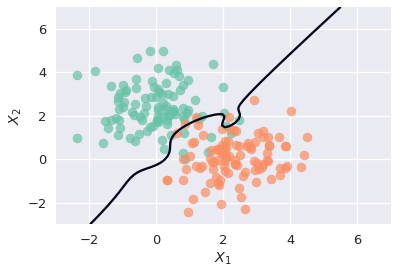

In [5]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_feats, y)

plot_decision_boundary(X, y, logreg.coef_)

In [6]:
accuracy_score(y_test, logreg.predict(X_test_feats))

0.9594594594594594

Because the model is too complex for the dataset, the decision boundary overfits to the training data in order to attain a higher accuracy. We can attempt to mitigate this issue by adding an L2 regularization penalty.

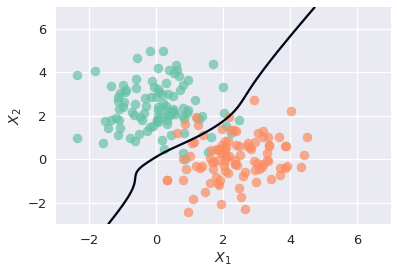

In [7]:
logreg_l2 = LogisticRegression(penalty='l2', C=0.01, random_state=42)
logreg_l2.fit(X_feats, y)

plot_decision_boundary(X, y, logreg_l2.coef_)

By adding the L2 regularization penalty, we have found a model that does a better job at separating the two classes while maintaining its ability to generalize to unseen data. This is reflected in the higher accuracy score.

In [8]:
accuracy_score(y_test, logreg_l2.predict(X_test_feats))

0.9797297297297297

If we set an L1 regularization penalty, we can build a sparse model that sets feature weights to 0, resulting in an even simpler model that extracts the pattern from the noise.

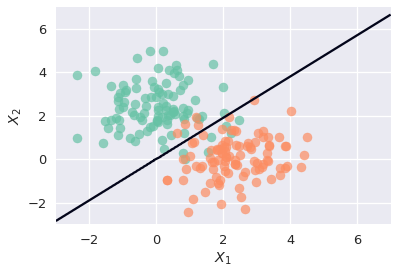

In [9]:
logreg_l1 = LogisticRegression(penalty='l1', C=0.01, random_state=42)
logreg_l1.fit(X_feats, y)

plot_decision_boundary(X, y, logreg_l1.coef_)

In [10]:
accuracy_score(y_test, logreg_l1.predict(X_test_feats))

0.9864864864864865